<h1 align="center">Predicting EUR/USD with LSTM Network</h1> 
<h3 align="center">Bradley Droegkamp</h3> 

# Introduction
***
Forex price prediction, much like stock price prediction, is a near impossible task given all the noise involved in price time series data.  However, profitable trading strategies can be made from models that provide only a sliver of edge.  In this analysis I will attempt to forecast price, provide a basic backtesting framework for evaluating models, and show some of the challenges associated with forecasting.

As for modeling and data, I will use a Long Short-Term Memory (LSTM - http://colah.github.io/posts/2015-08-Understanding-LSTMs/) network to predict the 5 minute future price of the front month EUR/USD futures contract (EU) listed on the Chicago Mercantile Exchange (CME - https://www.cmegroup.com/trading/fx/g10/euro-fx.html).  The model will focus on a small subset of trading hours (9:15 - 11:15AM CST).
<br>

# Data
***
The data set consists of 1-minute increment front-month EU price data from September 27, 2009 to April 18, 2018, though we will only use a subset. The data was purchased from a vendor of CME intraday data.  Note the data contains all open hours of trading, which is a 23 hour trading day of 17:00(t-1) - 16:00 CST Monday(Sunday PM) to Friday.

### Contract Details
<table class="cmeSpecTable" summary="Contract Specifications Product Table" cellspacing="0" cellpadding="2">
<tbody>
<tr>
<td class="prodSpecAtribute">Contract Unit</td>
<td colspan="5" style="text-align:left">125,000 euro</td>
</tr>
<tr>
<td class="prodSpecAtribute" rowspan="1">Trading Hours</td>
<td colspan="3" style="text-align:left">Sunday - Friday 6:00 p.m. - 5:00 p.m. (5:00 p.m. - 4:00 p.m. Chicago Time/CT) with a 60-minute break each day beginning at 5:00 p.m. (4:00 p.m. CT)</td>
</tr>
<tr>
<td class="prodSpecAtribute" rowspan="1">Minimum Price Fluctuation*</td>
<td colspan="3" style="text-align:left">Outrights: .00005 USD per EUR increments ($6.25 USD).<br />Consecutive Month Spreads: (Globex only)&nbsp;&nbsp;0.00001 USD per EUR (1.25 USD)<br />All other Spread Combinations: &nbsp;0.00005 USD per EUR (6.25 USD)</td>
</tr>
<tr>
<td class="prodSpecAtribute">Product Code</td>
<td colspan="5" style="text-align:left">CME Globex: 6E<br />CME ClearPort: EC<br />Clearing: EC</td>
</tr>
<tr>
<td class="prodSpecAtribute" rowspan="1">Listed Contracts</td>
<td colspan="5" style="text-align:left">Contracts listed for the first 3 consecutive months and 20 months in the March quarterly cycle (Mar, Jun, Sep, Dec)</td>
</tr>
<tr>
<td class="prodSpecAtribute">Settlement Method</td>
<td colspan="5" style="text-align:left">Deliverable</td>
</tr>
<tr>
<td class="prodSpecAtribute" rowspan="1">Termination Of Trading</td>
<td colspan="5" style="text-align:left">9:16 a.m. Central Time (CT) on the second business day immediately preceding the third Wednesday of the contract month (usually Monday).</td>
</tr>
<tr>
<td class="prodSpecAtribute">Settlement Procedures</td>
<td colspan="5" style="text-align:left">Physical Delivery<br /><a href="http://www.cmegroup.com/confluence/display/EPICSANDBOX/Euro" target="_blank">EUR/USD Futures Settlement Procedures&nbsp;</a></td>
</tr>
</tbody>
</table>

*Source:  https://www.cmegroup.com/trading/fx/g10/euro-fx_contract_specifications.html*

**Min Price Fluctuation changed from 0.0001 to 0.00005 on January 11, 2016 (https://www.cmegroup.com/trading/fx/half-tick.html)*

<br>

#### I.  Bring in the raw data.

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190226181440-0001
KERNEL_ID = 204b3c5b-e2ff-4cc6-a01e-f15190f40151
+----------+-----+------+------+------+------+------+
|      Date| Time|  Open|  High|   Low| Close|Volume|
+----------+-----+------+------+------+------+------+
|09/27/2009|18:00|  1.47|1.4701| 1.469|1.4691|   441|
|09/27/2009|18:01|1.4691|1.4691|1.4689| 1.469|    29|
|09/27/2009|18:02| 1.469| 1.469|1.4688|1.4688|    22|
|09/27/2009|18:03|1.4687|1.4691|1.4687|1.4691|    38|
|09/27/2009|18:04|1.4692|1.4693|1.4692|1.4692|    20|
|09/27/2009|18:05|1.4692|1.4693| 1.469|1.4691|    11|
|09/27/2009|18:06|1.4691|1.4692|1.4689|1.4692|    14|
|09/27/2009|18:07|1.4691|1.4691| 1.469| 1.469|     6|
|09/27/2009|18:08| 1.469|1.4691| 1.469|1.4691|     5|
|09/27/2009|18:09| 1.469|1.4692| 1.469|1.4692|     7|
|09/27/2009|18:10|1.4692|1.4692|1.4684|1.4685|    81|
|09/27/2009|18:11|1.4686|1.4687|1.4683|1.4686|    63|
|09/27/2009|18:12|1.4687|1.4688|1.

#### II.  Combine Date and Time columns.  Also, these times are in EST, but I prefer CST.

In [2]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, concat, col, lit, hour, minute, year, lag
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import datetime

# Convert Date and Time columns to Timestamps and combine
df_raw_2 = df_raw.select(unix_timestamp(concat(col('Date'), lit(' '), col('Time')), 'MM/dd/yyyy HH:mm')\
                   .cast(TimestampType()).alias('Timestamp'),
                   'Open', 'High', 'Low', 'Close', 'Volume')

# now substract hour from EST timestamps for CST
df = df_raw_2.select(from_unixtime(unix_timestamp(col('Timestamp')) - 60 * 60).alias('Timestamp'),
                    'Open', 'High', 'Low', 'Close', 'Volume')

df.createOrReplaceTempView('df')
df_2016 = spark.sql("SELECT * FROM df WHERE Timestamp BETWEEN '2016-01-01' AND '2016-12-31' ORDER BY Timestamp")

df_2016.show()

# pandas df for exploring at next step
pdf_plt = df_2016.toPandas()
pdf_plt.index = pd.to_datetime(pdf_plt.Timestamp)
pdf_plt.drop(['Timestamp'], axis=1, inplace=True)

+-------------------+------+------+------+------+------+
|          Timestamp|  Open|  High|   Low| Close|Volume|
+-------------------+------+------+------+------+------+
|2016-01-03 17:00:00|1.0884|1.0886|1.0882|1.0883|   215|
|2016-01-03 17:01:00|1.0884|1.0884|1.0881|1.0882|    48|
|2016-01-03 17:02:00|1.0883|1.0884|1.0882|1.0883|    37|
|2016-01-03 17:03:00|1.0884|1.0884|1.0879|1.0879|    51|
|2016-01-03 17:04:00|1.0878|1.0878|1.0873|1.0874|   133|
|2016-01-03 17:05:00|1.0874|1.0875|1.0874|1.0875|    47|
|2016-01-03 17:06:00|1.0875|1.0877|1.0874|1.0876|    24|
|2016-01-03 17:07:00|1.0876|1.0876|1.0875|1.0876|    10|
|2016-01-03 17:08:00|1.0876|1.0876|1.0876|1.0876|     3|
|2016-01-03 17:09:00|1.0875|1.0875|1.0874|1.0874|    40|
|2016-01-03 17:10:00|1.0875|1.0875|1.0873|1.0875|   146|
|2016-01-03 17:11:00|1.0875|1.0877|1.0874|1.0876|   195|
|2016-01-03 17:12:00|1.0877|1.0877|1.0877|1.0877|     6|
|2016-01-03 17:13:00|1.0876|1.0876|1.0876|1.0876|    10|
|2016-01-03 17:14:00|1.0877|1.0

#### III.  Explore Data

As expected, prices are not stationary.  We will use returns rather than price to get unbiased results from our model.

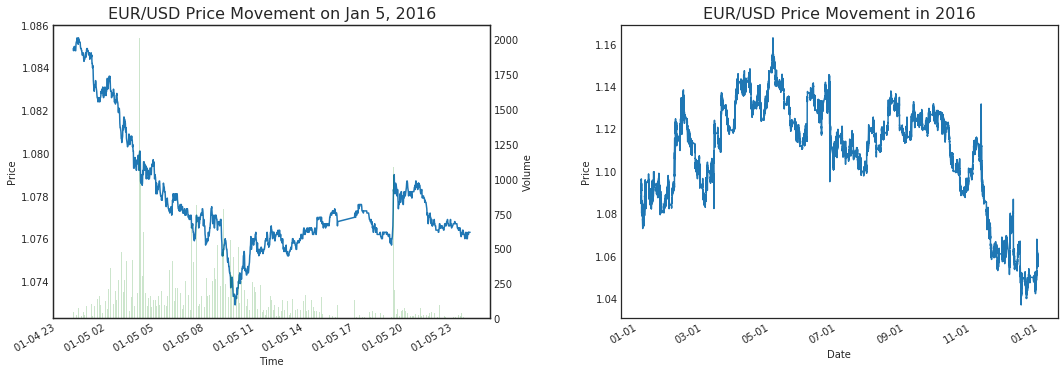

In [3]:
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

pdf_day = pdf_plt[(pdf_plt.index >= '2016-01-05') & (pdf_plt.index < '2016-01-06')]
sns.set_style("white")

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
fig.subplots_adjust(wspace=0.3)
pdf_day['Close'].plot(ax=ax[0])
ax[0].set_xlabel("Time")
ax[0].get_figure().autofmt_xdate()
xfmt = mdates.DateFormatter('%H:%M')
ax[0].xaxis.set_major_formatter(xfmt)
ax[0].set_ylabel("Price")
ax[0].set_title("EUR/USD Price Movement on Jan 5, 2016", fontsize=16)
ax2_sub1 = ax[0].twinx()
ax2_sub1.set_ylabel('Volume')
ax2_sub1.bar(pdf_day.index, pdf_day['Volume'], color='g', alpha=0.2, width = 0.5 / 1400)

pdf_plt['Close'].plot(ax=ax[1])
ax[1].set_xlabel("Date")
ax[1].get_figure().autofmt_xdate()
xfmt = mdates.DateFormatter('%m-%d')
ax[1].xaxis.set_major_formatter(xfmt)
ax[1].set_ylabel("Price")
ax[1].set_title("EUR/USD Price Movement in 2016", fontsize=16)
ax[1].get_figure().autofmt_xdate()


Volumes are more concentrated during US daytime hours.

Text(0.5,1,'Average Volume by Hour in 2016')

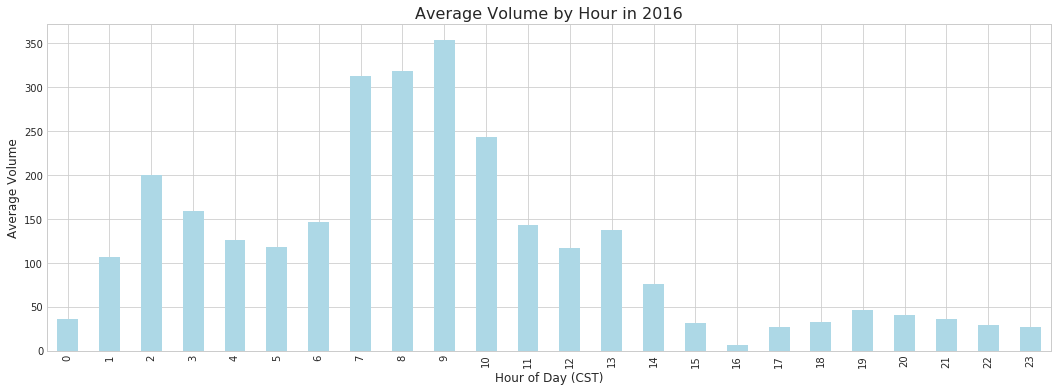

In [4]:
sns.set_style("whitegrid")
ax = pdf_plt.groupby(pdf_plt.index.hour)['Volume'].mean().plot.bar(figsize=(18, 6), color='lightblue', title="")
ax.set_xlabel("Hour of Day (CST)", fontsize=12)
ax.set_ylabel("Average Volume", fontsize=12)
ax.set_title("Average Volume by Hour in 2016", fontsize=16)

#### IV.  Set up data for next steps

Define functions for streamlined data processing

In [128]:
from pyspark.sql import functions as F
from sklearn.preprocessing import RobustScaler
sc_f = RobustScaler()
sc_y = RobustScaler()

def add_price_returns(df, x):
    '''
    Parameters: Pyspark df with "Close" price column, x minute parameter
    Returns: Pyspark df with added x price_xmin_return column
    '''
    df_return = df.withColumn('tmp_lag_price', lag(df.Close, count=x).over(Window.orderBy('Timestamp')))
    col_name = 'price_' + str(x) + 'min_return'
    df_return = df_return.withColumn(col_name, df_return.Close - df_return.tmp_lag_price).na.drop()
    return df_return.drop('tmp_lag_price')

def get_dates_times_subset(df, startYear, endYear, st, et):
    '''
    BE SURE TO INCLUDE ALL NEEDED DATA IN TIMESPAN!  
    Building forecast_window and prior time_window from this data should be considered.
    Parameters: Pyspark df with Timestamp column, startYear(YYYY), endYear(YYYY), start time (st), end time (et)
    Returns: Pyspark df between specified dates, specific times
    '''
    df_return = df.filter((year('Timestamp') >= lit(startYear)) & (year('Timestamp') <= lit(endYear)))\
                  .filter((hour('Timestamp') >= lit(st.hour)) & (hour('Timestamp') <= lit(et.hour)))\
                  .filter((hour('Timestamp') != lit(st.hour)) | (minute('Timestamp') >= lit(st.minute)))\
                  .filter((hour('Timestamp') != lit(et.hour)) | (minute('Timestamp') <= lit(et.minute)))
    return df_return

def add_dataset_check_col(df, startTime, endTime):
    '''
    Parameters: Pyspark df with Timestamp column, startTime(HH:MM), endTime(HH:MM)
    Returns: Pyspark df with "is_in_dataset" column, identifying rows that stay in dataset after final setup
    '''
    st = datetime.datetime.strptime(startTime, '%H:%M')
    et = datetime.datetime.strptime(endTime, "%H:%M")
    df_return = df.withColumn('is_in_dataset', ((hour('Timestamp') == lit(st.hour)) & (minute('Timestamp') >= lit(st.minute))) | \
                                        ((hour('Timestamp') == lit(et.hour)) & (minute('Timestamp') <= lit(et.minute))) | \
                                        ((hour('Timestamp') >= lit(min(st.hour + 1, et.hour))) & \
                                         (hour('Timestamp') <= lit(max(et.hour - 1, st.hour)))))
    return df_return

def get_arrays_for_lstm(df, time_window, forecast_window, batch_size):
    '''
    Assumes cols 5, 6 are price, volume features, 7 will be y var, and last col is datacheck bool
    Parameters: Pyspark df, time_window, forecast_window, batch_size
    Returns: Transformed 3D X and y np arrays for LSTM network model
    '''
    pdf = df.toPandas()
    
    # only need price returns and volumes, but keep dataset check vals for below
    feature_set = pdf.iloc[:, 5:7].values
    y_set = pdf.iloc[:, 7:8].values
    is_in_dataset_check = pdf.iloc[:, -1]

    # feature scaling
    feature_set_scaled = sc_f.fit_transform(np.float64(feature_set))
    y_set_scaled = sc_y.fit_transform(np.float64(y_set))

    # filter data into needed arrays
    x_price_train = []
    x_volume_train = []
    y_train = []

    length = len(feature_set_scaled)
    for i in range(0, length):
        x_volume_train.append(feature_set_scaled[max(0, i - time_window):i, 0])
        x_price_train.append(feature_set_scaled[max(0, i - time_window):i, 1])

    #not normalizing y var
    for i in range(0, len(y_set_scaled)):
        y_train.append(y_set_scaled[min(length, i+forecast_window):min(length, i+forecast_window)+1, 0])

    # now that we have the time_window data, remove unwanted entries based on prior is_in_dataset_check
    x_volume_train, x_price_train, y_train, is_in_dataset_check = \
        np.array(x_volume_train), np.array(x_price_train), np.array(y_train), np.array(is_in_dataset_check)
    x_volume_train = x_volume_train[is_in_dataset_check]
    x_price_train = x_price_train[is_in_dataset_check]
    y_train = y_train[is_in_dataset_check]

    # reduce size of dataset to be divisible by batch size
    x_volume_train = x_volume_train[0:len(x_volume_train) - len(x_volume_train)%batch_size]
    x_price_train = x_price_train[0:len(x_price_train) - len(x_price_train)%batch_size]
    y_train = y_train[0:len(y_train) - len(y_train)%batch_size]

    # combine and reshape for modeling
    x_volume_train = np.reshape(np.array(x_volume_train.tolist()), (x_volume_train.shape[0], 10))
    x_price_train = np.reshape(np.array(x_price_train.tolist()), (x_price_train.shape[0], 10))
    X_train = np.dstack((x_price_train, x_volume_train))
    y_train = np.reshape(np.array(y_train.tolist()), (y_train.shape[0], 1))
    print("Feature set shape (standardized price & volume w/10min window): ")
    print(X_train.shape)
    print(X_train[0])
    print('\n')
    print("y var shape (standardized 5min future price return): ")
    print(y_train.shape)
    print(y_train[0])
    print('\n')
    return X_train, y_train

def get_mlr_df(df, time_window, forecast_window):
    '''
    DOES NOT STANDARDIZE VARIABLES!
    Parameters: Pyspark df (with Timestamp, price_1min_return, Volume, and price_5min_return, is_in_dataset cols), 
                time_window, forecast_window
    Returns: Pyspark df with cols "sma_price", "sma_volume", "y_price"
    '''
    # add sma cols for price returns and volume (features)
    df_return = df.withColumn('sma_price', F.avg("price_1min_return")\
                              .over(Window.orderBy('Timestamp').rowsBetween(-time_window, 0)))
    df_return = df_return.withColumn('sma_volume', F.avg("Volume")\
                                     .over(Window.orderBy('Timestamp').rowsBetween(-time_window, 0)))
    
    # shift 5 min return col to line up y var
    df_return = df_return.withColumn('label', \
                                     lag(df.price_5min_return, count=-forecast_window).over(Window.orderBy('Timestamp')))

    # now that we have the time_window data, remove unwanted entries based on prior is_in_dataset_check
    df_return = df_return.filter(df.is_in_dataset)

    return df_return.drop('Open', 'High', 'Low', 'Close', 'Volume', 'price_1min_return', 'price_5min_return', 'is_in_dataset')

##### Data will be filtered to 9:15 - 11:15AM CST
 - Common economic releases between 7:15 - 9:00AM CST may bias data if included.
 - These are generally periods of higher volume and volatility.
 - This can be revisited for building models with specific time slots.
 - Train data set will be 2013 - 2015, validation data 2016, and 2017 for test data.

<br>

At this point, we will also define:
 - Lookback **Time window** used in the LSTM = **10 minutes**
 - **Batch size** = **64**
 - **Forecast window** = **5 minutes**

In [16]:
# define important data parameters
forecast_window = 5
time_window = 10
batch_size = 64
start_time = '09:15'
end_time = '11:15'

# add price returns columns
df = add_price_returns(df, 1)
df = add_price_returns(df, 5)

# set train data to year 2013-2015 (val data to 2016, test data to 2017)
# include only data between needed time windows (start to end time, plus time, forecast windows added accordingly)
st = datetime.datetime.strptime(start_time, '%H:%M') - datetime.timedelta(minutes = time_window)
et = datetime.datetime.strptime(end_time, '%H:%M') + datetime.timedelta(minutes = forecast_window)
df_train = get_dates_times_subset(df, 2013, 2015, st, et)
df_val   = get_dates_times_subset(df, 2016, 2016, st, et)
df_test  = get_dates_times_subset(df, 2017, 2017, st, et)

# add a column to later filter out fields not needed in final dataset.
df_train = add_dataset_check_col(df_train, start_time, end_time)
df_val   = add_dataset_check_col(df_val, start_time, end_time)
df_test  = add_dataset_check_col(df_test, start_time, end_time)

df_train.show(10, False)

+-------------------+------+------+------+------+------+----------------------+----------------------+-------------+
|Timestamp          |Open  |High  |Low   |Close |Volume|price_1min_return     |price_5min_return     |is_in_dataset|
+-------------------+------+------+------+------+------+----------------------+----------------------+-------------+
|2013-01-02 09:05:00|1.3266|1.3267|1.3265|1.3265|167   |-9.999999999998899E-5 |0.0                   |false        |
|2013-01-02 09:06:00|1.3266|1.3267|1.3265|1.3266|225   |9.999999999998899E-5  |0.0                   |false        |
|2013-01-02 09:07:00|1.3266|1.3266|1.3264|1.3265|299   |-9.999999999998899E-5 |-1.9999999999997797E-4|false        |
|2013-01-02 09:08:00|1.3264|1.3264|1.3263|1.3263|313   |-1.9999999999997797E-4|-3.9999999999995595E-4|false        |
|2013-01-02 09:09:00|1.3263|1.3263|1.3261|1.3261|184   |-1.9999999999997797E-4|-4.999999999999449E-4 |false        |
|2013-01-02 09:10:00|1.3262|1.3265|1.3261|1.3265|323   |3.999999

##### Set up data using Close price and Volume as features

In [102]:
# get arrays for lstm network model
X_train, y_train = get_arrays_for_lstm(df_train, time_window, forecast_window, batch_size)
X_test, y_test   = get_arrays_for_lstm(df_test, time_window, forecast_window, batch_size)
X_val, y_val     = get_arrays_for_lstm(df_val, time_window, forecast_window, batch_size)

Feature set shape (standardized price & volume w/10min window): 
(93504, 10, 2)
[[-0.5        -0.20141343]
 [ 0.5         0.00353357]
 [-0.5         0.26501767]
 [-1.          0.31448763]
 [-1.         -0.14134276]
 [ 2.          0.34982332]
 [ 1.          0.02473498]
 [-0.5         1.00353357]
 [-0.5        -0.13780919]
 [ 0.         -0.20848057]]


y var shape (standardized 5min future price return): 
(93504, 1)
[-1.16666667]
Feature set shape (standardized price & volume w/10min window): 
(31040, 10, 2)
[[  1.25         9.125     ]
 [  2.           4.91964286]
 [ -1.           2.45982143]
 [  1.5          2.20089286]
 [ -2.5          3.75446429]
 [ -2.           1.62946429]
 [ -1.           3.92857143]
 [ -2.25         4.95535714]
 [ -4.25        10.80803571]
 [  0.5          5.25892857]]


y var shape (standardized 5min future price return): 
(31040, 1)
[ 3.125]
Feature set shape (standardized price & volume w/10min window): 
(31168, 10, 2)
[[ -0.5          1.06167401]
 [ -1.5     

##### Finally, get data for Linear Regression benchmark model

 - Since our time_window for the LSTM model is 10 minutes, we'll use a **10 minute simple moving average (SMA) of both close price and volume** as features to predict 5 minute future returns for the MLR model.

In [8]:
# these will be kept in a pySpark dataframe so we can later show off a Pipeline assembly in Spark
mlr_train = get_mlr_df(df_train, time_window, forecast_window)
mlr_test  = get_mlr_df(df_test, time_window, forecast_window)

mlr_train.show(10, False)

+-------------------+----------------------+------------------+----------------------+
|Timestamp          |sma_price             |sma_volume        |label                 |
+-------------------+----------------------+------------------+----------------------+
|2013-01-02 09:15:00|-9.09090909090809E-6  |240.63636363636363|-6.999999999999229E-4 |
|2013-01-02 09:16:00|-9.09090909090809E-6  |242.45454545454547|-6.999999999999229E-4 |
|2013-01-02 09:17:00|-2.7272727272724268E-5|257.6363636363636 |-5.999999999999339E-4 |
|2013-01-02 09:18:00|-5.4545454545448536E-5|263.0             |-1.9999999999997797E-4|
|2013-01-02 09:19:00|-6.363636363637681E-5 |294.0             |-9.999999999998899E-5 |
|2013-01-02 09:20:00|-2.7272727272724268E-5|335.0             |-9.999999999998899E-5 |
|2013-01-02 09:21:00|-7.272727272726472E-5 |321.09090909090907|3.9999999999995595E-4 |
|2013-01-02 09:22:00|-9.09090909090809E-5  |323.0             |3.9999999999995595E-4 |
|2013-01-02 09:23:00|-8.18181818181728E-5  

# Methodology
***
### I.  Fit the LSTM network model

In [103]:
from keras.layers import Dense, Dropout, Input, LSTM
from keras.models import Sequential, load_model
import h5py

lstm = Sequential()
lstm.add(LSTM(40, batch_input_shape=(batch_size,time_window,2), return_sequences=True, recurrent_dropout = 0.1))
lstm.add(LSTM(30, recurrent_dropout = 0.2))
lstm.add(Dropout(0.2))
lstm.add(Dense(20, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(5, activation='relu'))
lstm.add(Dense(1))
lstm.compile(loss= 'mae', optimizer= 'adam')
lstm_history = lstm.fit(X_train, y_train, epochs=5, batch_size=batch_size, shuffle=True, validation_data=(X_val, y_val))

lstm.save(filepath="lstm.h5")

Train on 93504 samples, validate on 31168 samples
Epoch 1/5
93504/93504 [==============================] - 54s 581us/step - loss: 0.5761 - val_loss: 0.6755
Epoch 2/5
93504/93504 [==============================] - 51s 551us/step - loss: 0.5758 - val_loss: 0.6758
Epoch 3/5
93504/93504 [==============================] - 52s 556us/step - loss: 0.5758 - val_loss: 0.6758
Epoch 4/5
93504/93504 [==============================] - 52s 557us/step - loss: 0.5756 - val_loss: 0.6759
Epoch 5/5
93504/93504 [==============================] - 52s 557us/step - loss: 0.5756 - val_loss: 0.6756


### I.  Fit Linear Regression Model

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# set up pipeline to define features, standardize, and instantiate Linear Regression model
vectorAssembler = VectorAssembler(inputCols=["sma_price", "sma_volume"], outputCol="features")
normalizer = Normalizer(inputCol="features", outputCol="features_norm", p=1.0)
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[vectorAssembler, normalizer,lr])

# fit LR model
lr_model = pipeline.fit(mlr_train)

lr_model.save("lr_model.h5")

### II.  Compare Mean Absolute Error on Test Data

Based on this metric, it appears the Linear Regression model outperformed the LSTM network model **(BUT SEE RESULTS SECTION)**

In [126]:
from sklearn.metrics import mean_absolute_error
from pyspark.ml.evaluation import RegressionEvaluator

lstm_pred = lstm.predict(X_test, batch_size=batch_size)
lstm_mae = mean_absolute_error(sc_y.inverse_transform(y_test), sc_y.inverse_transform(lstm_pred))

lr_pred = lr_model.transform(mlr_test)
mae_eval = RegressionEvaluator().setMetricName("mae") .setPredictionCol("prediction").setLabelCol("label")
lr_mae = mae_eval.evaluate(lr_pred)

print('LSTM Mean Absolute Error (Test set): ' + str(round(lstm_mae, 5)))
print(' MLR Mean Absolute Error (Test set): ' + str(round(lr_mae, 5)))

LSTM Mean Absolute Error (Test set): 0.00034
 MLR Mean Absolute Error (Test set): 0.00028


# Results
***
### Both models fit test data *well* with LSTM network outperforming...
 - ***BUT predictions are very near to 0!***
   - MLR model is always 0!
 - The 5 minute ahead predictions tend to be near equal to existing price.
 - This is intuitive:  Majority of minute-by-minute price changes oscillate around 0.  So predictions are inline with this.
   - Unfortunately, that shows us price forecasting is difficult!

In [106]:
# 4 charts here:  2 price returns, test v pred, lstm, lr.  2 prices, same.  Pick one day!
# 2 more charts?  historgrams
#plt.hist(sc_y.inverse_transform(lstm_pred))

# Visualising the results
#plt.plot(sc_y.inverse_transform(y_test), color = 'red', label = 'Actual Price Returns')
#plt.plot(sc_y.inverse_transform(lstm_pred), color = 'green', label = 'Predicted Price Returns')
#plt.title('Actual v Predicted Price Returns')
#plt.xlabel('Time')
#plt.ylabel('Crude Oil Prices')
#plt.legend()
#plt.show()

### Alternatively, a classification metric can be created to assess and compare model accuracy

Accuracy:  Prediction Direction Correct / Total

In [127]:
# Accuracy, as calculated based on  (Prediction Direction Correct / Total), here for LSTM and LR

# Discussion
***
### Can a pricing model offer profit opportunities?
 - A basic Backtester can answer this
   - Backtester will enter long position if price return > **threshold**, short if price return < **threshold**, and get flat if back to price return reverts to 0.
   - Parameters include:
     - **threshold**: This is specified above.
     - **slippage**: Amount of payup to enter a trade beyond closing price.  Should consider bid/ask spread and transaction costs. 
 - Reminder of CME EUR/USD Contract details:
     - Money Per Point:  125,000
     - Minimum Tick:  0.00005
     - $6.25 / tick

In [130]:
#backtester here, with profit output, chart

### Future considerations
 - list here.  also put references here

# Conclusion
***
Price forecasting is difficult.